# Analyzing simulated COVID-19 Patient Data
For the Data Processes assignment given at UPM in 2021, simulated covid-19 patient data is analyzed.
The data contains information on personal data and medical parameters collected when they were firstly
admitted in ER: temperature, heart rate, blood glucose, O 2 saturation, systolic blood
pressure, and diastolic blood pressure.

## EDA + Data Prep

In [1]:
# Make sure special packages are installed
#!pip install missingo
#!pip install kaplanmeier

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import kaplanmeier as km

%matplotlib inline

In [3]:
df = pd.read_csv("COVID19_data.csv")

# Drop ID col as it is redundent
df = df.drop(['ID'], axis = 1)
df.head(10)

,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
0,15.0,FEMALE,4,0,NO,NaN,37.0,0,0,92,0,0
1,18.0,FEMALE,4,0,NO,ADMISSION,37.3,105,0,97,0,0
2,21.0,MALE,7,0,NO,NaN,38.5,112,0,95,85,47
3,21.0,MALE,10,0,NO,ADMISSION,39.2,113,0,97,0,0
4,22.0,MALE,4,0,NO,NaN,36.3,80,0,92,111,70
5,22.0,MALE,7,0,NO,NaN,37.2,101,0,98,160,84
6,23.0,FEMALE,5,0,NO,NaN,0.0,0,0,0,0,0
7,23.0,FEMALE,4,0,NO,NaN,37.0,99,0,98,0,0
8,24.0,MALE,3,0,NO,NaN,0.0,0,0,0,0,0
9,24.0,MALE,6,0,NO,NaN,36.0,115,0,82,127,68


In [4]:
print(f"The data set has {df.shape[0]} rows and {df.shape[1]} columns.")

The data set has 2054 rows and 12 columns.


In [5]:
# Seperate numerical and categorical values
num_vars = df.columns[df.dtypes != 'object']
cat_var = df.columns[df.dtypes == 'object']

print(num_vars)
print(cat_var)
print(df.SEX.value_counts())
print(df.EXITUS.value_counts())
print(df.DESTINATION.value_counts())

Index(['AGE', 'DAYS_HOSPITAL', 'DAYS_ICU', 'TEMP', 'HEART_RATE', 'GLUCOSE',
       'SAT_O2', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS'],
      dtype='object')
Index(['SEX', 'EXITUS', 'DESTINATION'], dtype='object')
MALE      1227
FEMALE     825
Name: SEX, dtype: int64
NO     1684
YES     329
Name: EXITUS, dtype: int64
ADMISSION    671
Name: DESTINATION, dtype: int64


In [6]:
# Descriptive statistics on numerical data
df.describe()

,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,2050.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000
mean,70.856585,8.118793,0.355404,28.386319,70.787731,1.776047,73.397760,83.571568,48.328140
std,20.456931,6.177872,2.173721,15.419158,41.802038,20.434622,37.863716,67.450853,44.225438
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.000000,4.000000,0.000000,35.400000,63.000000,0.000000,81.000000,0.000000,0.000000
50%,68.000000,7.000000,0.000000,36.400000,84.000000,0.000000,93.000000,115.000000,64.000000
75%,98.000000,10.000000,0.000000,36.900000,98.000000,0.000000,96.000000,137.000000,79.000000
max,189.000000,98.000000,36.000000,40.100000,593.000000,448.000000,99.000000,772.000000,845.000000


### Observations
Question that come up when looking at this data are:
* Can Patients be at the hospital for 0 days?
* Do we need to assume that heart_rate, glucose, sat_o2, blood_pres_sys and blood_pres_dias cannot be 0 and those entries are erroneous?
* The max values for heart_rate, glucose, blood_pres_sys and blood_pres_dias seems strange. Are these erroneous too?

### Actions taken
There are different approaches that can be chosen when dealing with erronouse data.
First they are replaced with missing values.
Now the options are to either dicard all rows or even entire columns, if there is too much missing data.
Or, to replace these values with, e.g average values or other interpolation techniques.

In [7]:
df.loc[df['BLOOD_PRES_DIAS'] == 0,'BLOOD_PRES_DIAS'] = np.nan
df.loc[df['BLOOD_PRES_SYS'] == 0,'BLOOD_PRES_SYS'] = np.nan
df.loc[df['TEMP'] == 0,'TEMP'] = np.nan
df.loc[df['HEART_RATE'] == 0,'HEART_RATE'] = np.nan
df.loc[df['GLUCOSE'] == 0,'GLUCOSE'] = np.nan
df.loc[df['SAT_O2'] == 0,'SAT_O2'] = np.nan

print("Missing values percentage:")
df.isnull().sum().sort_values(ascending=False)/len(df)*100

Missing values percentage:


GLUCOSE            99.074976
DESTINATION        67.332035
BLOOD_PRES_SYS     36.514119
BLOOD_PRES_DIAS    36.514119
TEMP               22.736125
HEART_RATE         21.811100
SAT_O2             20.545278
EXITUS              1.996105
AGE                 0.194742
SEX                 0.097371
DAYS_HOSPITAL       0.000000
DAYS_ICU            0.000000
dtype: float64

Drop Glucose as 99% of that data is missing.
Drop Destination too? Better understand variale and meaning of missing values first.

In [8]:
df = df.drop(['GLUCOSE'], axis=1)
small_df = df.drop(['DESTINATION', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS'], axis=1)

The data set has 1502 rows and 8 columns.


AGE              0.0
SEX              0.0
DAYS_HOSPITAL    0.0
DAYS_ICU         0.0
EXITUS           0.0
TEMP             0.0
HEART_RATE       0.0
SAT_O2           0.0
dtype: float64

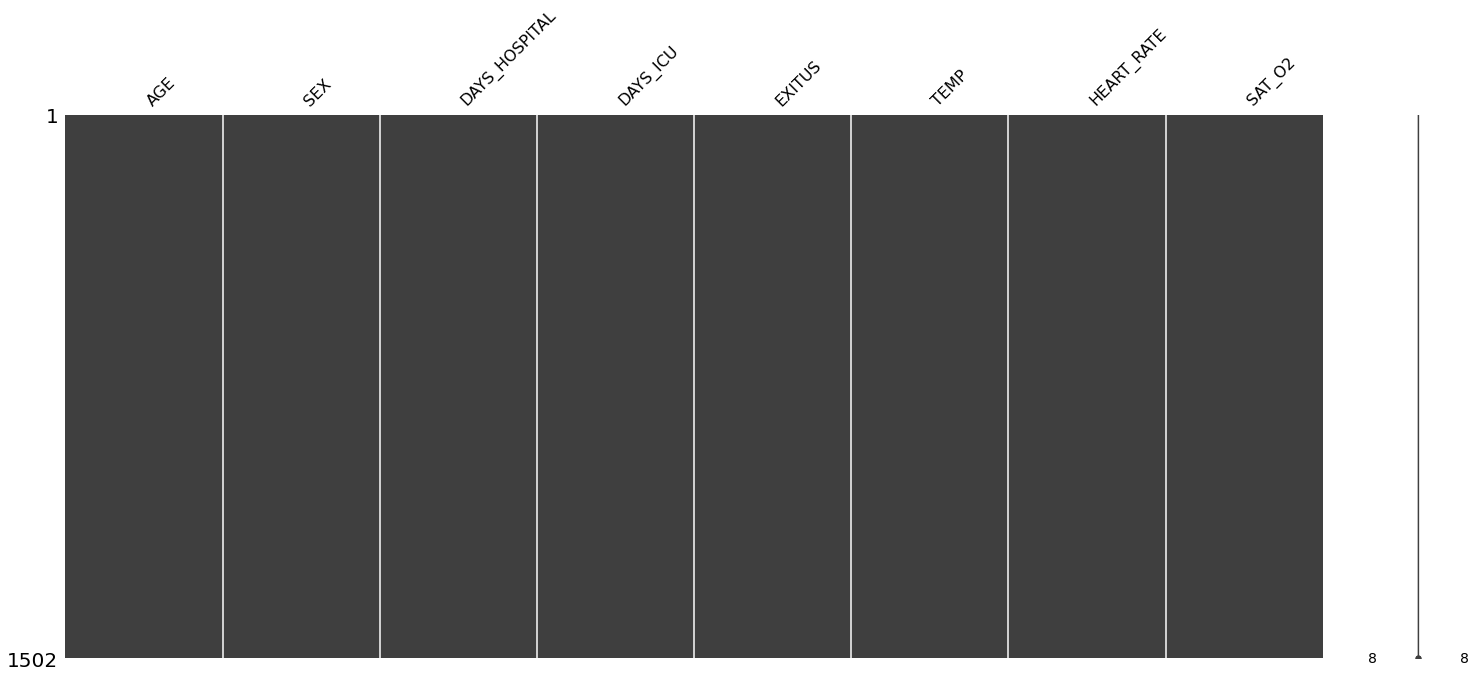

In [33]:
small_df = small_df[(small_df['AGE'] <= 120)]
small_df = small_df[small_df.AGE.notnull() & small_df.SEX.notnull() & small_df.EXITUS.notnull() & small_df.SAT_O2.notnull() & small_df.HEART_RATE.notnull() & small_df.TEMP.notnull()]
print(f"The data set has {small_df.shape[0]} rows and {small_df.shape[1]} columns.")
msno.matrix(small_df)
small_df.isnull().sum().sort_values(ascending=False)/len(df)*100

<AxesSubplot:>

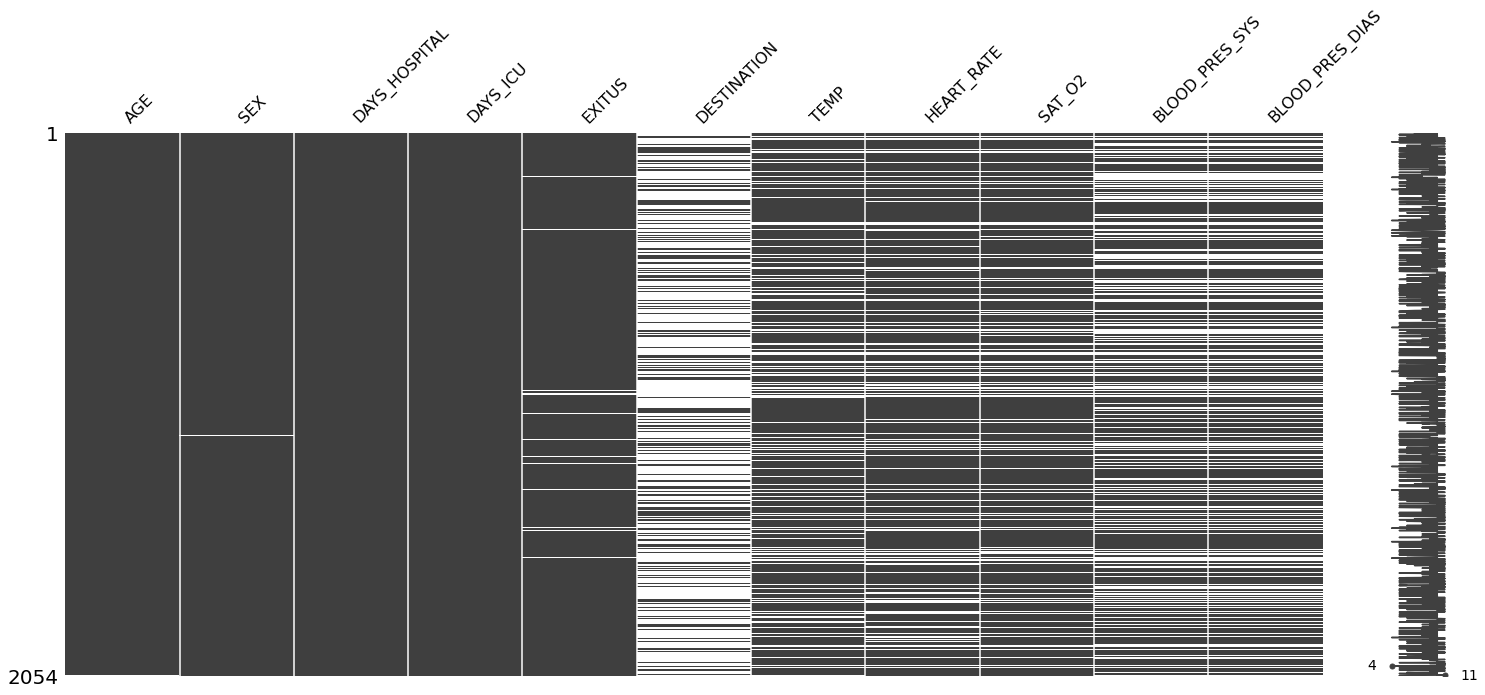

In [9]:
msno.matrix(df)

In [10]:
df.describe()

,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,2050.000000,2054.000000,2054.000000,1587.000000,1606.000000,1632.000000,1304.000000,1304.000000
mean,70.856585,8.118793,0.355404,36.739445,90.534247,92.376838,131.638037,76.124233
std,20.456931,6.177872,2.173721,0.820770,21.126081,7.092247,28.915777,31.050103
min,15.000000,0.000000,0.000000,33.200000,21.000000,10.000000,10.000000,11.000000
25%,57.000000,4.000000,0.000000,36.200000,78.250000,91.000000,117.000000,66.750000
50%,68.000000,7.000000,0.000000,36.600000,89.000000,94.000000,131.000000,76.000000
75%,98.000000,10.000000,0.000000,37.200000,101.000000,96.000000,146.000000,84.000000
max,189.000000,98.000000,36.000000,40.100000,593.000000,99.000000,772.000000,845.000000


# Outlier Detection
Visual representation of the quantiles to better understand if the max values are outliers.

<AxesSubplot:>

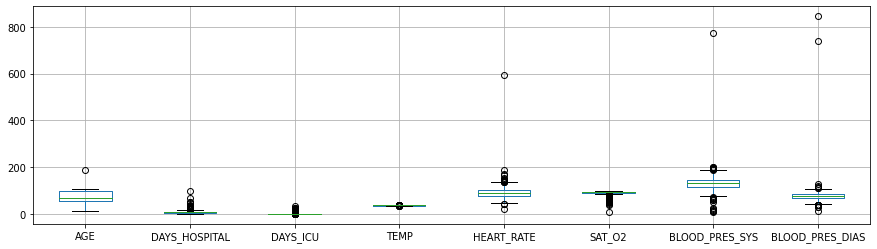

In [11]:
plt.figure(figsize=(15,4))
df.boxplot()

In [12]:
#plt.boxplot(df['AGE'])

Heuristic approach to removing erronouse data points based on contact with the data set provider and general knowledge on the topic. E.g. The heart rate of a human cannot be 600bpm. Is is impossible.

In [13]:
df = df[(df['AGE'] <= 120)]
df = df[(df['BLOOD_PRES_SYS'] <= 220)]
df = df[(df['BLOOD_PRES_DIAS'] <= 220)]
print(f"The data set has {df.shape[0]} rows and {df.shape[1]} columns.")

#df = df[(df['TEMP'] != 0)] # 1584
#df = df[(df['HEART_RATE'] != 0) & (df['HEART_RATE'] <= 220)] # 1535

The data set has 1301 rows and 11 columns.


<AxesSubplot:>

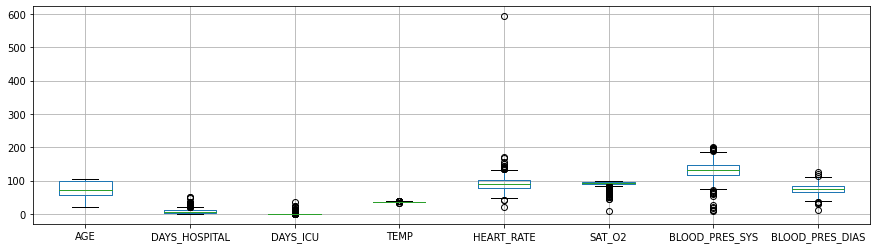

In [14]:
plt.figure(figsize=(15,4))
df.boxplot()

In [15]:
print(f"The data set has {df.shape[0]} rows and {df.shape[1]} columns.")

The data set has 1301 rows and 11 columns.


# Look for missing data

<AxesSubplot:>

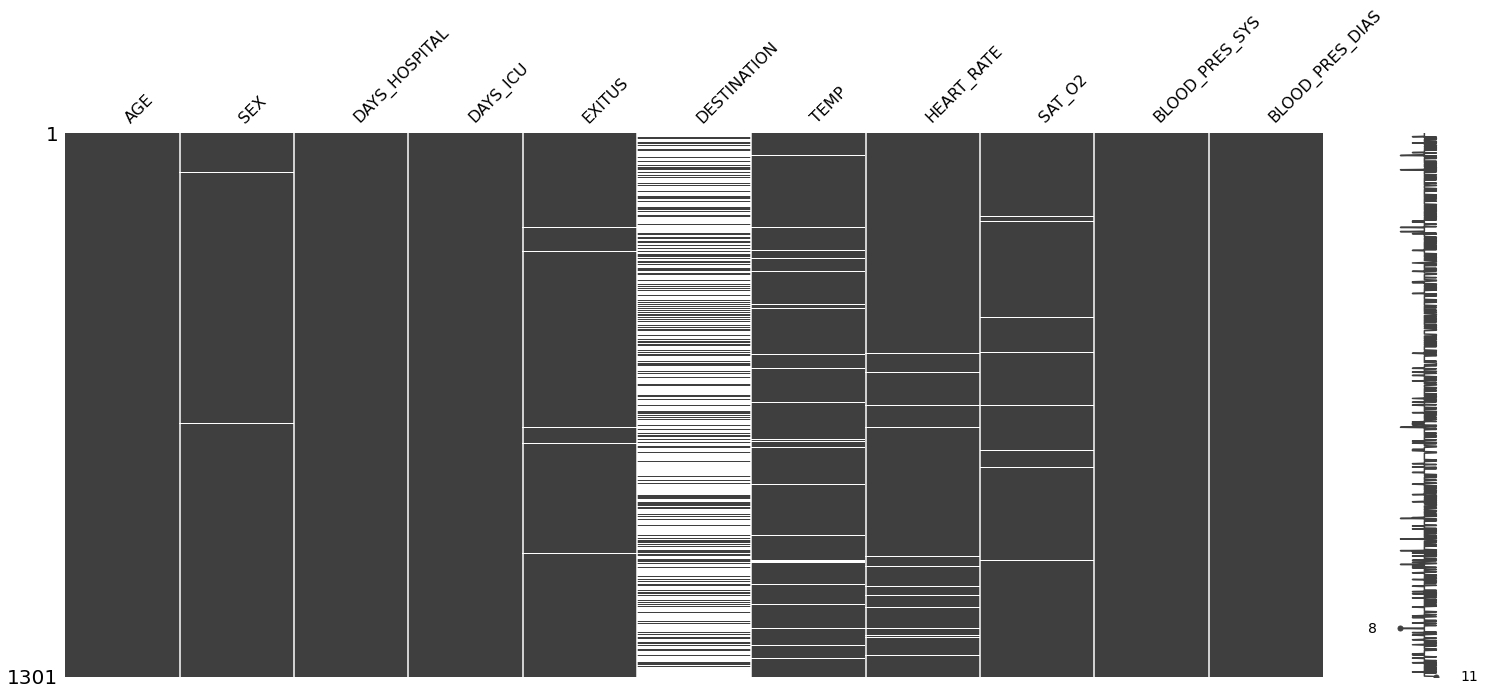

In [16]:
msno.matrix(df)

In [17]:
print("Missing values count:")
df.isnull().sum().sort_values(ascending=False) #/len(df)

Missing values count:


DESTINATION        857
TEMP                61
HEART_RATE          28
SAT_O2              25
EXITUS              17
SEX                  2
AGE                  0
DAYS_HOSPITAL        0
DAYS_ICU             0
BLOOD_PRES_SYS       0
BLOOD_PRES_DIAS      0
dtype: int64

There are a few columns with missing data. They will have to be dealt with in different ways.

As only a very small percentage of the data set is missing values for SEX or AGE, these rows will just be omitted.
A main goal of this analysis is to learn about the survival conditions of COVID-19 patients, so, all rows missing data on EXITUS will be dropped too. It is still a small percentage of the total data set.
The DESTINATION column is missing quiet a lot of values. A quick further look into this variable might help to decide how to procede.

<AxesSubplot:>

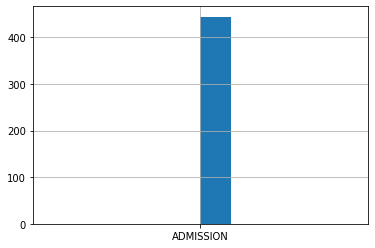

In [18]:
df['DESTINATION'].hist()

There are only the states admission and missing values. 
The assumption now is that missing values represent not admitted.
This needs to be verified with the data set provider.

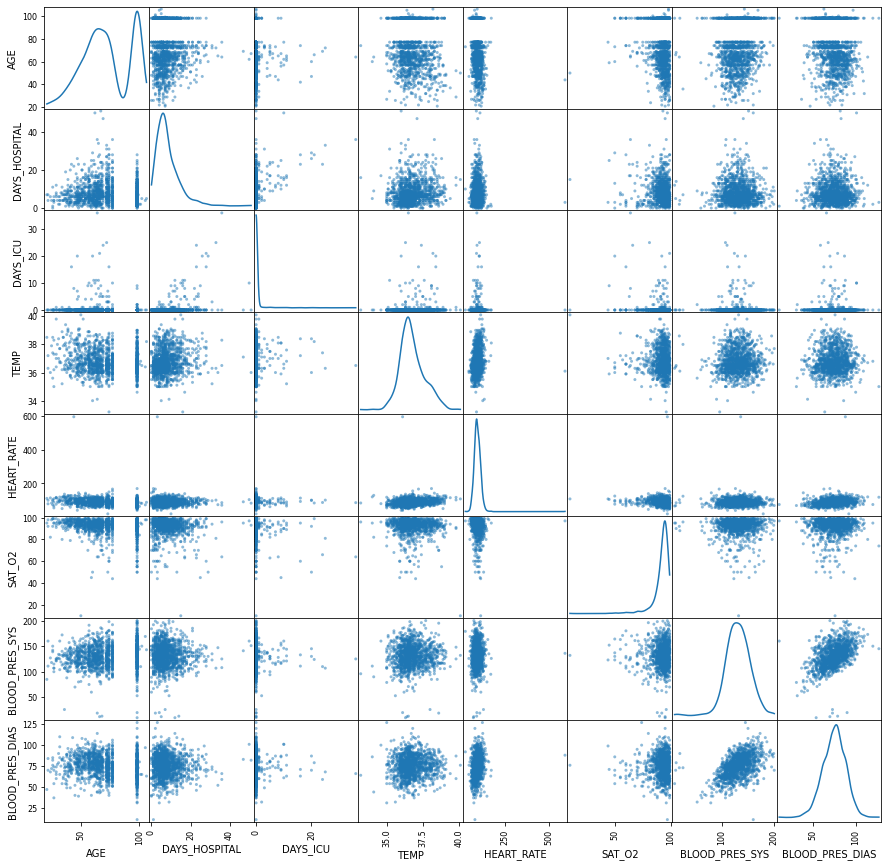

In [19]:
scat_matrix = pd.plotting.scatter_matrix(df, figsize=(15,15), diagonal="kde")

array([[<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'DAYS_HOSPITAL'}>,
        <AxesSubplot:title={'center':'DAYS_ICU'}>],
       [<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'HEART_RATE'}>,
        <AxesSubplot:title={'center':'SAT_O2'}>],
       [<AxesSubplot:title={'center':'BLOOD_PRES_SYS'}>,
        <AxesSubplot:title={'center':'BLOOD_PRES_DIAS'}>, <AxesSubplot:>]],
      dtype=object)

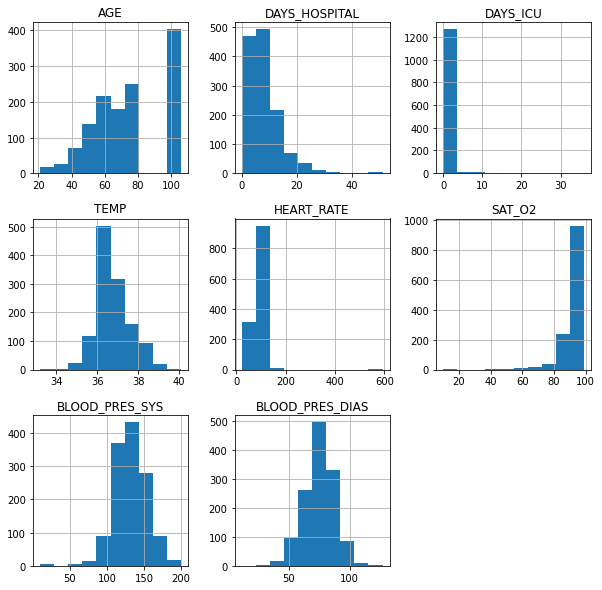

In [20]:
df.hist(figsize=(10,10))

In [21]:
df = df[df.AGE.notnull() & df.SEX.notnull() & df.EXITUS.notnull()]

In [22]:
print(f"The data set has {df.shape[0]} rows and {df.shape[1]} columns.")

The data set has 1282 rows and 11 columns.


In [23]:
df[cat_var].value_counts()

SEX     EXITUS  DESTINATION
MALE    NO      ADMISSION      207
FEMALE  NO      ADMISSION      167
MALE    YES     ADMISSION       42
FEMALE  YES     ADMISSION       24
dtype: int64

## Univariate analysis 

In [24]:
# Histograms

# Boxplot

# Scatterplot

## think about differentiating between exitus

## Multivariate analysis 

Multiple Regression Analysis

## Survival curves (Keplan-Meier)

## ML Model
Predicting survival

In [25]:
# Imbalance Ratio
df.EXITUS.value_counts(normalize=True)

NO     0.822933
YES    0.177067
Name: EXITUS, dtype: float64

In [26]:
def printMeanAndSdByGroup(variables, groupvariable):
    data_groupby = variables.groupby(groupvariable)
    print("## Means:")
    display(data_groupby.apply(np.mean))
    print("\n## Standard deviations:")
    display(data_groupby.apply(np.std))
    print("\n## Sample sizes:")
    display(pd.DataFrame(data_groupby.apply(len)))
    
printMeanAndSdByGroup(df, df.EXITUS)

## Means:


/home/ellomarshmallow/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
EXITUS,,,,,,,,
NO,68.869194,8.151659,0.195261,36.771443,90.583253,93.119231,131.591469,75.890995
YES,88.682819,7.867841,0.792952,36.731429,89.903670,86.502304,129.387665,71.048458



## Standard deviations:


/home/ellomarshmallow/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
EXITUS,,,,,,,,
NO,19.393162,5.432894,1.419491,0.833740,22.689827,5.642662,22.082802,12.592274
YES,13.805950,7.582740,3.836567,0.874051,18.519637,11.270501,25.891836,14.520298



## Sample sizes:


,0
EXITUS,
NO,1055
YES,227


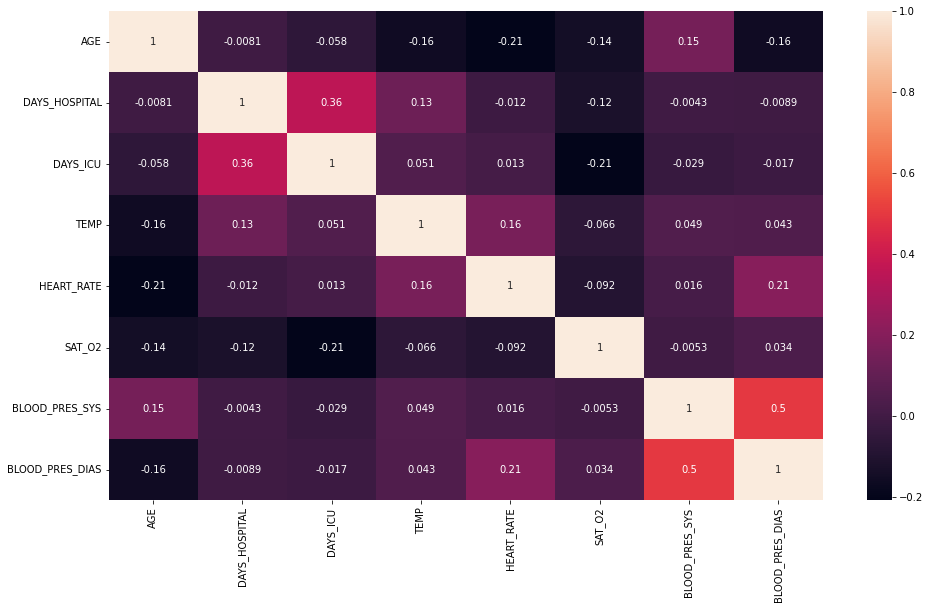

In [27]:
plt.figure(figsize=(16,9))
ax = sns.heatmap(df.corr(), annot=True)

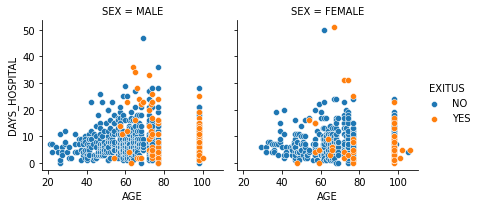

In [28]:
g = sns.FacetGrid(df, col="SEX", hue='EXITUS')
g.map(sns.scatterplot, "AGE", "DAYS_HOSPITAL")
g.add_legend()

In [29]:
#PCA?
# Linear discriminant analysis is also known as canonical discriminant analysis, or simply discriminant analysis? 
# Clustering